In [1]:
using Distributions
using LaTeXStrings
using Optim
using Roots
using StatsFuns
using StatsPlots
default(fmt=:png, legendfontsize=12, guidefontsize=12)

In [2]:
function confint_score(k, n, α = 0.05)
    α == 0 && return [0.0, 1.0]
    z = cquantile(Normal(), α/2)
    p̂ = k/n
    sehat² = p̂ * (1 - p̂) / n
    a, b = 1 + z^2/n, p̂ + z^2/(2n)
    sqrtD = z * √(sehat² + z^2/(4n^2))
    p_L = (b - sqrtD) / a
    p_U = (b + sqrtD) / a
    [p_L, p_U]
end

function confint_wald(k, n, α = 0.05)
    z = cquantile(Normal(), α/2)
    p̂ = k/n
    sehat = √(p̂ * (1 - p̂) / n)
    p_L = p̂ - z*sehat
    p_U = p̂ + z*sehat
    [p_L, p_U]
end

function confint_agresti_coull(k, n, α = 0.05)
    α == 0 && return [0.0, 1.0]
    z = cquantile(Normal(), α/2)
    k̃, ñ = k + z^2/2, n + z^2
    confint_wald(k̃, ñ, α)
end

function _equal_tailed_interval(quantilefunc::Function, α=0.05)
    [quantilefunc(α/2), quantilefunc(1-α/2)]
end

equal_tailed_interval(dist, α=0.05) =
    _equal_tailed_interval(p -> quantile(dist, p), α)

credint_eti(k, n, α=0.05) = equal_tailed_interval(Beta(1/3+k, 1/3+(n-k)), α)

function _highest_density_interval(linkfunc::Function, quantilefunc::Function, α=0.05; alg=Brent())
    α = α ≈ 1 ? oftype(float(α), 1 - √(eps())) : float(α)
    f(p) = linkfunc(quantilefunc(p + (1 - α))) - linkfunc(quantilefunc(p))
    o = optimize(f, 0, α, alg)
    p = o.minimizer
    [quantilefunc(p), quantilefunc(min(1, p+(1-α)))]
end

function highest_density_interval(linkfunc::Function, dist, α=0.05; alg=Brent())
    _highest_density_interval(linkfunc, p -> quantile(dist, p), α; alg)
end

highest_density_interval(dist, α=0.05; alg=Brent()) =
    highest_density_interval(identity, dist, α; alg)

credint_hdi(k, n, α=0.05) = highest_density_interval(Beta(1+k, 1+(n-k)), α)

function credint_hdi_logit(k, n, α=0.05)
    k == 0 && return [0.0, 0.0]
    k == n && return [1.0, 1.0]
    highest_density_interval(logit, Beta(k, n-k), α)
end

credint_hdi_logit (generic function with 2 methods)

In [3]:
r(x) = round(x; sigdigits=4)

k, n, α = 7, 10, 0.05
@show k n α
println()
@show hdi0 = credint_hdi_logit(k, n, α) .|> r
@show hdi1 = credint_hdi(k, n, α) .|> r
@show eti2 = credint_eti(k, n, α) .|> r
@show confint_score(k, n, α) .|> r
@show confint_wald(k, n, α) .|> r
@show confint_agresti_coull(k, n, α) .|> r;

k = 7
n = 10
α = 0.05

hdi0 = credint_hdi_logit(k, n, α) .|> r = [0.3845, 0.9195]
hdi1 = credint_hdi(k, n, α) .|> r = [0.412, 0.9066]
eti2 = credint_eti(k, n, α) .|> r = [0.3959, 0.9131]
confint_score(k, n, α) .|> r = [0.3968, 0.8922]
confint_wald(k, n, α) .|> r = [0.416, 0.984]
confint_agresti_coull(k, n, α) .|> r = [0.3923, 0.8967]


In [12]:
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_score(k, n, p)
    0 ≤ p ≤ 1 || return zero(p)
    bin = Binomial(n, p)
    z = safediv(k - mean(bin), std(bin))
    2ccdf(Normal(), abs(z))
end

function pvalue_wald(k, n, p)
    p̂ = k/n
    z = safediv(k - n*p, √(n*p̂*(1-p̂)))
    2ccdf(Normal(), abs(z))
end

# z²に関する3次方程式
function _eq_agresti_coull(z², k, n, p)
    k̃, ñ = k + z²/2, n + z²
    ñ * (k̃ - ñ*p)^2 - z² * k̃ * (ñ - k̃)
end

# z²に関する3次方程式の正値解
function z²_agresti_coull(k, n, p)
    f(t) = _eq_agresti_coull(exp(t), k, n, p)
    (1 - p ≈ 1 || p ≈ 1) && return oftype(p, Inf)
    k ≈ n*p && return zero(p)
    z² = exp(find_zero(f, (-1e2, 1e2)))
end

function pvalue_agresti_coull(k, n, p)
    0 ≤ p ≤ 1 || return zero(p)
    2ccdf(Normal(), √z²_agresti_coull(k, n, p))
end

function pvalue_eti(dist::ContinuousUnivariateDistribution, x)
    min(1, 2cdf(dist, x), 2ccdf(dist, x))
end

function pvalue_eti(k, n, p; beta = Beta(1/3+k, 1/3+(n-k)))
    pvalue_eti(beta, p)
end

function _pvalue_hdi(logpdffunc, cdffunc, xmin, xmax, x₀;
        xmode = optimize(x -> -logpdffunc(x), xmin, xmax, Brent()).minimizer)
    #@show logistic(x₀)
    logp₀ = logpdffunc(x₀)
    #@show exp(logp₀)
    f(x) = logpdffunc(x) - logp₀
    if x₀ ≈ xmode
        1.0
    elseif x₀ > xmode
        f(xmin)*f(xmode) < 0 || return 0.0
        #@show logistic(xmin) logistic(xmode)
        #@show f(xmin) f(xmode)
        x₁ = find_zero(f, (xmin, xmode))
        cdffunc(x₁) + (1 - cdffunc(x₀))
    else
        f(xmode)*f(xmax) < 0 || return 0.0
        #@show logistic(xmode) logistic(xmax)
        #@show f(xmode) f(xmax)
        x₁ = find_zero(f, (xmode, xmax))
        cdffunc(x₀) + (1 - cdffunc(x₁))
    end
end

function pvalue_hdi(k, n, p₀; beta=Beta(1+k, 1+(n-k)), pmode=k/n, pmin=0.0, pmax=1.0)
    k == 0 && return cdf(beta, p)
    k == n && return ccdf(beta, p)
    p == 1 && return 0.0
    _pvalue_hdi(p->logpdf(beta, p), p->cdf(beta, p), pmin, pmax, p₀; xmode=pmode)
end

function pvalue_hdi_logit(k, n, p₀; κ=0, λ=0, xmin=-1e2, xmax=1e2)
    κ+k == 0 && return float(p ≤ 0)
    λ+(n-k) == 0 && return float(p ≥ 1)
    0 < p < 1 || return 0.0
    beta = Beta(κ+k, λ+(n-k))
    logpdffunc(x) = let p = logistic(x); (κ+k)*log(p) + (λ+(n-k))*log(1-p) end
    cdffunc(x) = cdf(beta, logistic(x))
    _pvalue_hdi(logpdffunc, cdffunc, xmin, xmax, logit(p₀); xmode=logit((κ+k)/(κ+λ+n)))
end

pvalue_hdi_logit (generic function with 1 method)

In [5]:
r(x) = round(x; sigdigits=4)

k, n, p = 16, 20, 0.95
@show k n p
@show pvalue_hdi_logit(k, n, p) |> r
@show pvalue_hdi(k, n, p) |> r
@show pvalue_eti(k, n, p) |> r
@show pvalue_score(k, n, p) |> r
@show pvalue_wald(k, n, p) |> r
@show pvalue_agresti_coull(k, n, p) |> r
;

k = 16
n = 20
p = 0.95
pvalue_hdi_logit(k, n, p) |> r = 0.02057
pvalue_hdi(k, n, p) |> r = 0.01521
pvalue_eti(k, n, p) |> r = 0.0
pvalue_score(k, n, p) |> r = 0.002084
pvalue_wald(k, n, p) |> r = 0.09353
pvalue_agresti_coull(k, n, p) |> r = 0.008371


confint_score(k, n) .|> r = [0.397, 0.892]
confint_agresti_coull(k, n) .|> r = [0.392, 0.897]
confint_wald(k, n) .|> r = [0.416, 0.984]
highest_density_interval(logit, beta) .|> r = [0.384, 0.92]
highest_density_interval(beta1) .|> r = [0.412, 0.907]
equal_tailed_interval(beta2) .|> r = [0.396, 0.913]


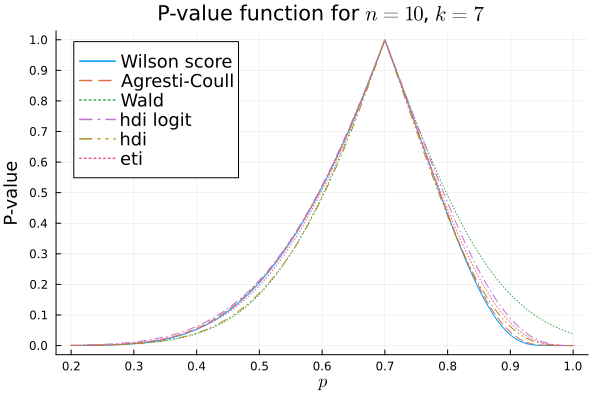

In [13]:
#pgfplotsx()
gr()

k, n = 7, 10
beta = Beta(k, n-k)
beta1 = Beta(1+k, 1+(n-k))
beta2 = Beta(1/3+k, 1/3+(n-k))

r(x) = round(x; sigdigits=3)
@show confint_score(k, n) .|> r
@show confint_agresti_coull(k, n) .|> r
@show confint_wald(k, n) .|> r
@show highest_density_interval(logit, beta) .|> r
@show highest_density_interval(beta1) .|> r
@show equal_tailed_interval(beta2) .|> r

plot()
plot!(p -> pvalue_score(k, n, p), 0.2, 1; label="Wilson score", c=1)
plot!(p -> pvalue_agresti_coull(k, n, p); label="Agresti-Coull", ls=:dash, c=2)
plot!(p -> pvalue_wald(k, n, p); label="Wald", ls=:dot, c=3)
plot!(p -> pvalue_hdi_logit(k, n, p); label="hdi logit", ls=:dashdot, c=4)
plot!(p -> pvalue_hdi(k, n, p); label="hdi", ls=:dashdotdot, c=5)
plot!(p -> pvalue_eti(k, n, p); label="eti", ls=:dot, c=7)
plot!(legend=:topleft)
title!(L"P-value function for $n=%$n$, $k=%$k$")
plot!(xtick=-0.2:0.1:1.2, ytick=0:0.1:1)
plot!(xguide=L"p", yguide="P-value")
#plot!(size=(500, 350))

In [14]:
function expectval(f, dist)
    μ, σ = mean(dist), std(dist)
    xmin = max(minimum(dist), round(Int, μ - 5σ))
    xmax = min(maximum(dist), round(Int, μ + 5σ))
    sum(x -> f(x)*pdf(dist, x), xmin:xmax)
end

bein(ci, x) = first(ci) ≤ x ≤ last(ci)

covprobfuncs(n; α=0.05) = (
    (p -> expectval(k -> pvalue_score(k, n, p) ≥ α, Binomial(n, p)), "Wilson score"),
    (p -> expectval(k -> pvalue_agresti_coull(k, n, p) ≥ α, Binomial(n, p)), "Agresti-Coull"),
    (p -> expectval(k -> pvalue_wald(k, n, p) ≥ α, Binomial(n, p)), "Wald score"),
    (p -> expectval(k -> bein(credint_hdi_logit(k, n), p), Binomial(n, p)), "hdi logit"),
    (p -> expectval(k -> bein(credint_hdi(k, n), p), Binomial(n, p)), "hdi"),
    (p -> expectval(k -> bein(credint_eti(k, n), p), Binomial(n, p)), "eti"),
)

function plot_covprib(; n=10, α=0.05)
    PP = []
    for (i, (covprobfunc, name)) in enumerate(covprobfuncs(n; α))
        ps = 0.001:0.001:0.999
        P = plot(ps, covprobfunc; label="", c=i)
        title!(L"%$(name): $n=%$n$, $\alpha=%$(100α)\% $")
        push!(PP, P)
    end
    plot((isodd(i) ? PP[div(i,2)+1] : PP[div(i,2)+3] for i in eachindex(PP))...; size=(1000, 750), layout=(3, 2))
    plot!(ylim=(0.9, 1.001))
    plot!(plot_title="Coverage probability")
end

plot_covprib (generic function with 1 method)

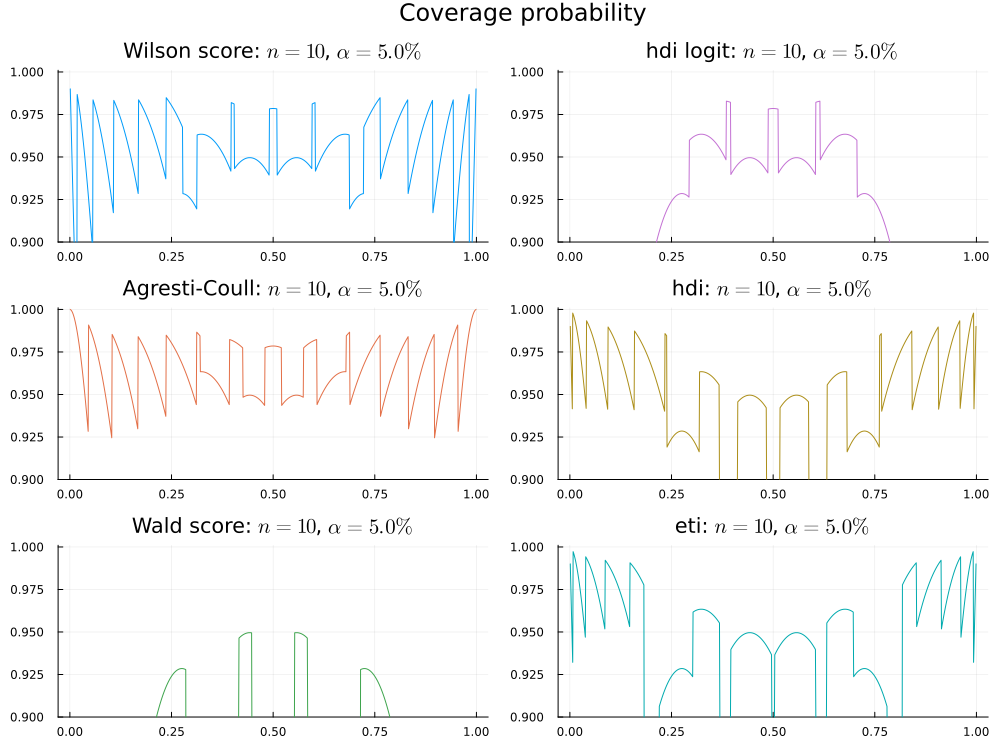

In [15]:
plot_covprib(; n = 10)

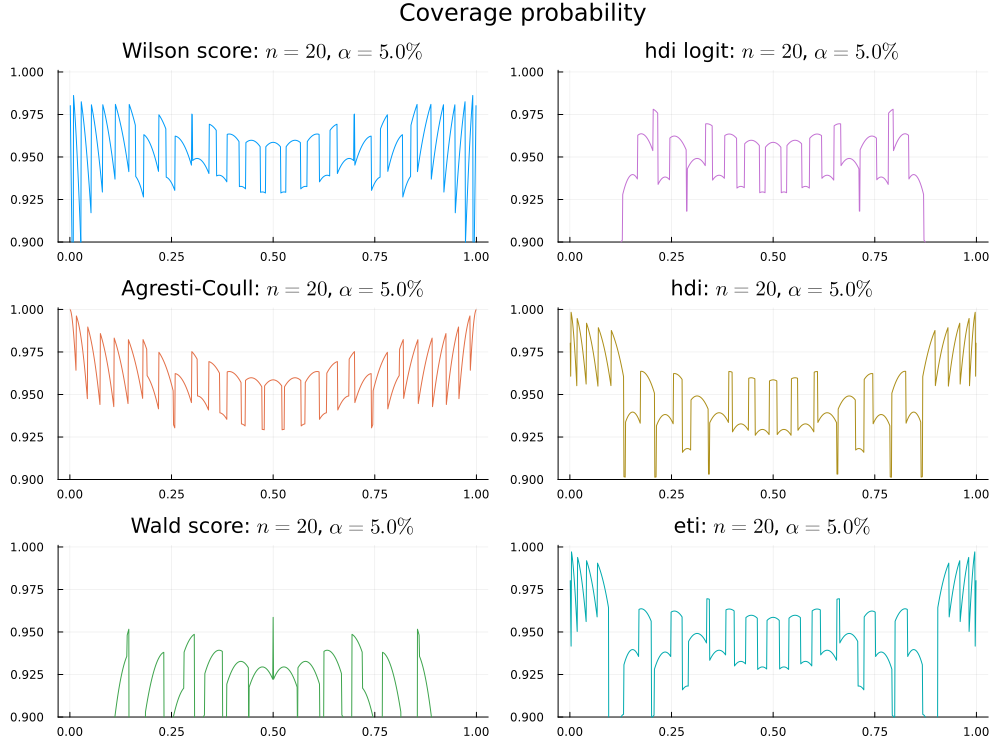

In [16]:
plot_covprib(; n = 20)

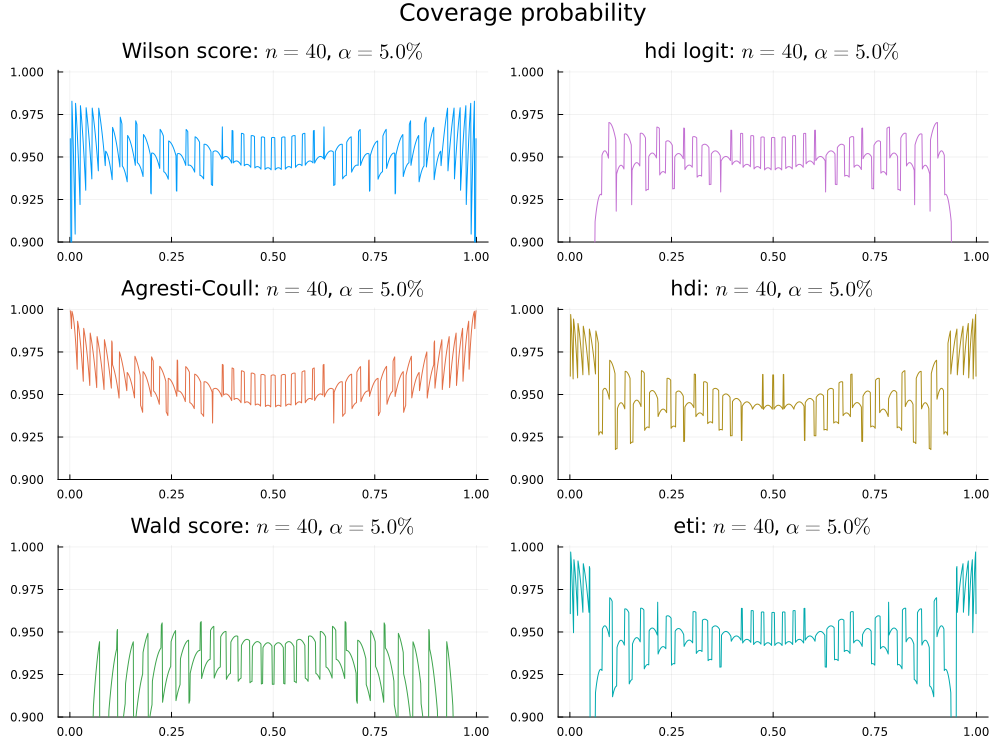

In [9]:
plot_covprib(; n = 40)

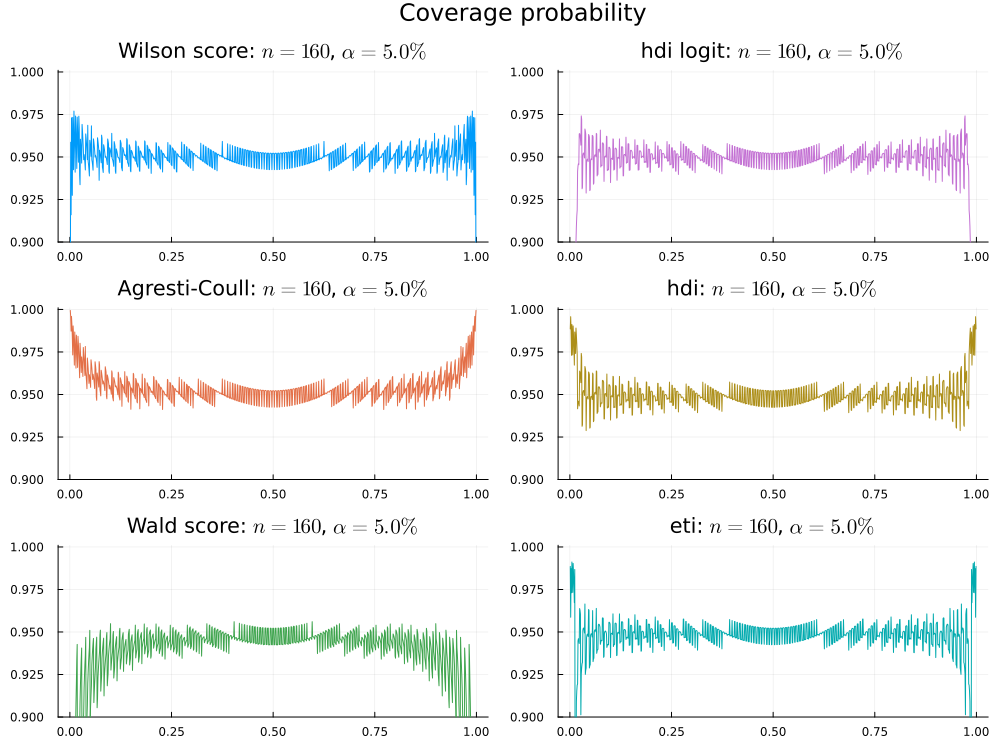

In [10]:
plot_covprib(; n = 160)

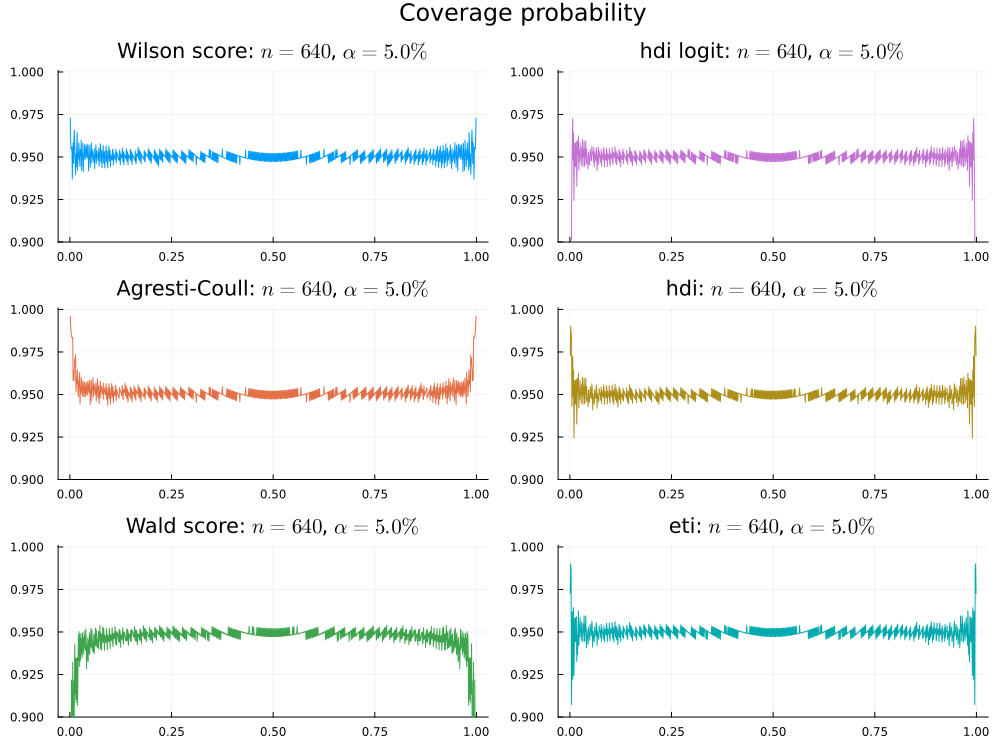

In [11]:
plot_covprib(; n = 640)